In [1]:
PROCESSES_COUNT = 20

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, model_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 1500 result folders
Loading data with 20 processes...


100%|██████████| 1500/1500 [00:43<00:00, 34.46it/s]


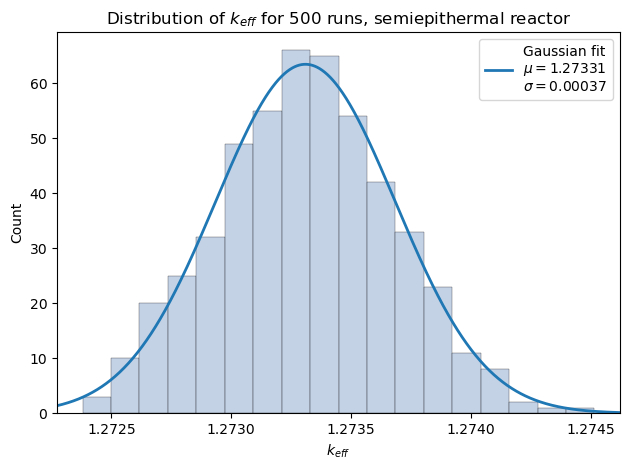

In [2]:
importlib.reload(plot_tools)
importlib.reload(model_tools)

# PLOT SETTINGS:
REACTOR_MODEL = model_tools.SEMIEPITHERMAL_REACTOR
USE_SAMPLED_DATA = True

SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

folder_name = f"plots-{REACTOR_MODEL}-{SAMPLED_STRING}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{REACTOR_MODEL}-{SAMPLED_STRING}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["reactor_model"] == REACTOR_MODEL]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

plt.figure()
fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs, {REACTOR_MODEL.lower()} reactor", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

# plt.figure()
# fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
#                                         fit_gaussian=True, decimals=0,
#                                         title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
#                                         filename=get_filename("heatmap", "distribution-rho"))

In [3]:
importlib.reload(plot_tools)
importlib.reload(data_tools)
importlib.reload(model_tools)
import pickle

# Create a dataframe from the results
df = pd.DataFrame(results)

# TMC analysis
for REACTOR_MODEL in [model_tools.SEMIEPITHERMAL_REACTOR]:
    tmc_v1_res = data_tools.perform_TMC_v1(df, REACTOR_MODEL, print_output=True)

    # Save dict to pickle file
    with open(f"R24-tmc_v1_res-{REACTOR_MODEL}.pkl", "wb") as f:
        pickle.dump(tmc_v1_res, f)

    print("")


TMC analysis v1
SEMIEPITHERMAL
Sampling all MTs
Based on 500 runs
 -- k_eff --
k_eff: 		1.273
σ_obs: 		3.64e-04
σ_stat_mean: 	3.15e-04
σ_ND: 		1.83e-04
R_obs: 		28.6 pcm
R_stat_mean: 	24.7 pcm
R_ND: 		14.4 pcm
 -- ρ --
ρ: 		21464.6 pcm
ρ-std: 		11.3 pcm



In [2]:
# TMC analysis 15 april 2023, to get table for paper

importlib.reload(plot_tools)
importlib.reload(data_tools)
importlib.reload(model_tools)
import pickle

# Create a dataframe from the results
df = pd.DataFrame(results)

table_results = []

# TMC analysis
for REACTOR_MODEL in [model_tools.THERMAL_REACTOR, model_tools.SEMIEPITHERMAL_REACTOR, model_tools.EPITHERMAL_REACTOR]:
    tmc_v1_res = data_tools.perform_TMC_v1(df, REACTOR_MODEL, print_output=False)

    if tmc_v1_res is None:
        print(f"\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
        print(f"Skipping {REACTOR_MODEL} as no results were found\n")
        continue


    u_k = tmc_v1_res["u_k"]
    u_rho = tmc_v1_res["u_rho"]

    # print(tmc_v1_res)
    table_results.append({
        "Reactor model": REACTOR_MODEL.capitalize(),
        "$k_{eff}$": float(f"{u_k.nominal_value:.4f}"),
        "$\sigma_{k_{eff}}$ [pcm]": float(f"{u_k.std_dev*1e5:.1f}"),
        "$\sigma_{k_{eff}}/k_{eff}$ [%]": float(f"{u_k.std_dev/u_k.nominal_value*100:.2f}"),
        r"$\rho$": float(f"{u_rho.nominal_value:.4f}"),
        r"$\sigma_{\rho}$ [pcm]": float(f"{u_rho.std_dev*1e5:.1f}"),
    })

    print(tmc_v1_res)

df_for_table = pd.DataFrame(table_results)
table = df_for_table.to_latex(index=False, escape=False)
print(table)

{'sigma_obs': 0.00034621732161805116, 'sigma2_obs': 1.1986643378837709e-07, 'sigma_stat_mean': 0.0003145601497309456, 'sigma2_stat_mean': 9.89480877987549e-08, 'sigma_ND': 0.00014463175996171166, 'sigma2_ND': 2.091834598962218e-08, 'k_eff_mean': 1.3653292376287829, 'R_obs': 0.0002535779005358, 'R_stat_mean': 0.00023039142579064204, 'R_ND': 0.00010593178258813157, 'u_k': 1.3653292376287829+/-0.00014463175996171166, 'u_rho': 0.2675759278862756+/-7.758698756946505e-05, 'N_ITERATIONS': 500, 'reactor_model': 'THERMAL'}
{'sigma_obs': 0.00036399411683481225, 'sigma2_obs': 1.3249171709035496e-07, 'sigma_stat_mean': 0.0003147693559022738, 'sigma2_stat_mean': 9.907974741513232e-08, 'sigma_ND': 0.00018278941346594075, 'sigma2_ND': 3.341196967522264e-08, 'k_eff_mean': 1.2733113928553226, 'R_obs': 0.0002858641797106502, 'R_stat_mean': 0.0002472053243758566, 'R_ND': 0.00014355436894037893, 'u_k': 1.2733113928553226+/-0.00018278941346594075, 'u_rho': 0.21464615363445272+/-0.00011274097580990545, 'N_I

/tmp/ipykernel_32086/2460398739.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df_for_table.to_latex(index=False, escape=False)


In [5]:
importlib.reload(plot_tools)
importlib.reload(data_tools)
import pickle

# TMC analysis v1 and v3 to see OpenMC discrepancies

# Create a dataframe from the results
df = pd.DataFrame(results)

for REACTOR_MODEL in [model_tools.THERMAL_REACTOR, model_tools.SEMIEPITHERMAL_REACTOR, model_tools.EPITHERMAL_REACTOR]:
    tmc_v1_res = data_tools.perform_TMC_v1(df, REACTOR_MODEL, print_output=False)
    tmc_v3_res = data_tools.perform_TMC_v3(df, REACTOR_MODEL, print_output=False)

    print("")


No data for THERMAL (not sampled)

No data for SEMIEPITHERMAL (not sampled)

No data for EPITHERMAL (not sampled)

